# PPD: Programação com CUDA

Professor: Hélio - DC/UFSCar - 2023

Aluno: Vitor de Almeida Recoaro - DC/UFSCar - 2023

In [1]:
! if [ ! -d files ]; \
then \
    mkdir files ; \
fi

## Paralelização com CUDA com estrutura 2D x 2D
### Estrutura com blocos 2D e grids 2D

In [2]:
%%writefile files/mm_cuda_2d.cu

#include <stdio.h>
#include <stdlib.h>
#include <omp.h>
#include <string.h>
#include <math.h>
#define TYPE double

void generateRandMatrix(TYPE *matrix, int nElem);
void showMatrix(TYPE *matrix, int nElem);
__global__ void multMatricesGPU(TYPE *matrixA, TYPE *matrixB, TYPE *matrixC, int nElem);

int main(int argv, char *argc[]){
    int nElem = 5;
    int blockSize = 32;
    TYPE *d_A, *d_B, *d_C, *h_A, *h_B, *C_Cuda;
    dim3 block, grid;
    cudaEvent_t start, stop;
    float elapsedTime;

    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    if(argv > 1){
        nElem = atoi(argc[1]);
        if (argv > 2){
            blockSize = atoi(argc[2]);
        }
    }

    block.x = blockSize;
    block.y = blockSize;
    block.z = 1;

    grid.x = (nElem + block.x - 1)/block.x;
    grid.y = (nElem + block.y - 1)/block.y;
    grid.z = 1;

    cudaMalloc(&d_A, nElem * nElem * sizeof(TYPE));
    cudaMalloc(&d_B, nElem * nElem * sizeof(TYPE));
    cudaMalloc(&d_C, nElem * nElem * sizeof(TYPE));
    h_A = (TYPE*) malloc(nElem * nElem * sizeof(TYPE));
    h_B = (TYPE*) malloc(nElem * nElem * sizeof(TYPE));
    C_Cuda = (TYPE*) malloc(nElem * nElem * sizeof(TYPE));

    generateRandMatrix(h_A, nElem);
    generateRandMatrix(h_B, nElem);

    cudaMemcpy(d_A, h_A, nElem * nElem * sizeof(TYPE), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, nElem * nElem * sizeof(TYPE), cudaMemcpyHostToDevice);
    cudaEventRecord(start, 0);
    multMatricesGPU<<< grid, block >>>(d_A, d_B, d_C, nElem);
    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&elapsedTime, start, stop);
    cudaMemcpy(C_Cuda, d_C, nElem * nElem * sizeof(TYPE), cudaMemcpyDeviceToHost);

    printf("%f\n", elapsedTime);

    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);
    free(h_A);
    free(h_B);
    free(C_Cuda);
    cudaEventDestroy(start);
    cudaEventDestroy(stop);
}

// Calculate the multiplication of matrices with CUDA support.
__global__ void multMatricesGPU(TYPE *matrixA, TYPE *matrixB, TYPE *matrixC, int nElem){
    unsigned int x = blockIdx.x * blockDim.x + threadIdx.x;
    unsigned int y = blockIdx.y * blockDim.y + threadIdx.y;
    int i;
    TYPE sum = 0;

    if(x < nElem && y < nElem){
        for (i = 0; i < nElem; i++){
            sum += matrixA[x * nElem + i] * matrixB[i * nElem + y];
        }
    }

    matrixC[x * nElem + y] = sum;
}

void showMatrix(TYPE *matrix, int nElem){
    int i;

    for (i = 0; i < nElem * nElem; i++){
        printf("%f ", matrix[i]);
    }

    printf("\n");
}

// Generate Matrix with TYPE values between [0...1000]
void generateRandMatrix(TYPE *matrix, int nElem){
    int i;
    int tam = nElem * nElem;
    unsigned int seed = time(NULL);

    #pragma omp parallel for
    for (i = 0; i < tam; i++){
        matrix[i] = ((TYPE) rand_r(&seed) / (TYPE) RAND_MAX) * 1000;
    }
}

Overwriting files/mm_cuda_2d.cu


In [3]:
! nvcc files/mm_cuda_2d.cu -o files/mm_cuda_2d-prog
! ./files/mm_cuda_2d-prog 2048 1 > files/cuda_2D_2048_1.out
! ./files/mm_cuda_2d-prog 2048 2 > files/cuda_2D_2048_2.out
! ./files/mm_cuda_2d-prog 2048 4 > files/cuda_2D_2048_4.out
! ./files/mm_cuda_2d-prog 2048 8 > files/cuda_2D_2048_8.out
! ./files/mm_cuda_2d-prog 2048 16 > files/cuda_2D_2048_16.out
! ./files/mm_cuda_2d-prog 2048 32 > files/cuda_2D_2048_32.out

## Paralelização com CUDA com estrutura 1D x 1D
### Estrutura de blocos 1D e grids 1D

In [4]:
%%writefile files/mm_cuda_1d.cu
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <omp.h>
#include <string.h>
#include <math.h>
#define TYPE double


void generateRandMatrix(TYPE *matrix, int nElem);
void showMatrix(TYPE *matrix, int nElem);
__global__ void multMatricesGPU(TYPE *matrixA, TYPE *matrixB, TYPE *matrixC, int nElem);

int main(int argv, char *argc[]){
int nElem = 5;
    int blockSize = 1024;
    TYPE *d_A, *d_B, *d_C, *h_A, *h_B, *C_Cuda;
    dim3 block, grid;
    cudaEvent_t start, stop;
    float elapsedTime;

    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    if(argv > 1){
        nElem = atoi(argc[1]);
        if (argv > 2){
            blockSize = atoi(argc[2]);
        }
    }

    block.x = blockSize;
    block.y = 1;
    block.z = 1;

    grid.x = (nElem *nElem + block.x - 1)/block.x;
    grid.y = 1;
    grid.z = 1;

    cudaMalloc(&d_A, nElem * nElem * sizeof(TYPE));
    cudaMalloc(&d_B, nElem * nElem * sizeof(TYPE));
    cudaMalloc(&d_C, nElem * nElem * sizeof(TYPE));
    h_A = (TYPE*) malloc(nElem * nElem * sizeof(TYPE));
    h_B = (TYPE*) malloc(nElem * nElem * sizeof(TYPE));
    C_Cuda = (TYPE*) malloc(nElem * nElem * sizeof(TYPE));

    generateRandMatrix(h_A, nElem);
    generateRandMatrix(h_B, nElem);

    cudaMemcpy(d_A, h_A, nElem * nElem * sizeof(TYPE), cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, nElem * nElem * sizeof(TYPE), cudaMemcpyHostToDevice);
    cudaEventRecord(start, 0);
    multMatricesGPU<<< grid, block >>>(d_A, d_B, d_C, nElem);
    cudaEventRecord(stop, 0);
    cudaEventSynchronize(stop);
    cudaEventElapsedTime(&elapsedTime, start, stop);
    cudaMemcpy(C_Cuda, d_C, nElem * nElem * sizeof(TYPE), cudaMemcpyDeviceToHost);

    printf("%f\n", elapsedTime);

    cudaFree(d_A);
    cudaFree(d_B);
    cudaFree(d_C);
    free(h_A);
    free(h_B);
    free(C_Cuda);
    cudaEventDestroy(start);
    cudaEventDestroy(stop);
}

// Calculate the multiplication of matrices with CUDA support.
__global__ void multMatricesGPU(TYPE *matrixA, TYPE *matrixB, TYPE *matrixC, int nElem){
    unsigned int idx = blockDim.x * blockIdx.x + threadIdx.x;
    unsigned int x = idx / nElem;
    unsigned int y = idx % nElem;
    int i;
    TYPE sum = 0.0;

    if(x < nElem && y < nElem){
        for (i = 0; i < nElem; i++){
            sum += matrixA[x * nElem + i] * matrixB[i * nElem + y];
        }
    }

    matrixC[x * nElem + y] = sum;
}

void showMatrix(TYPE *matrix, int nElem){
    int i;

    for (i = 0; i < nElem * nElem; i++){
        printf("%f ", matrix[i]);
    }

    printf("\n");
}

// Generate Matrix with TYPE values between [0...1000]
void generateRandMatrix(TYPE *matrix, int nElem){
    int i;
    int tam = nElem * nElem;
    unsigned int seed = time(NULL);

    #pragma omp parallel for
    for (i = 0; i < tam; i++){
        matrix[i] = ((TYPE) rand_r(&seed) / (TYPE) RAND_MAX) * 1000;
    }
}


Overwriting files/mm_cuda_1d.cu


In [5]:
! nvcc files/mm_cuda_1d.cu -o files/mm_cuda_1d-prog
! ./files/mm_cuda_1d-prog 2048 1 > files/cuda_1D_2048_1.out
! ./files/mm_cuda_1d-prog 2048 4 > files/cuda_1D_2048_4.out
! ./files/mm_cuda_1d-prog 2048 16 > files/cuda_1D_2048_16.out
! ./files/mm_cuda_1d-prog 2048 64 > files/cuda_1D_2048_64.out
! ./files/mm_cuda_1d-prog 2048 256 > files/cuda_1D_2048_256.out
! ./files/mm_cuda_1d-prog 2048 1024 > files/cuda_1D_2048_1024.out

[5099.526855, 1417.748535, 674.907471, 674.077209, 672.01593, 636.809143, 5293.214355, 1377.888916, 415.449371, 368.547668, 619.713013, 621.914673]


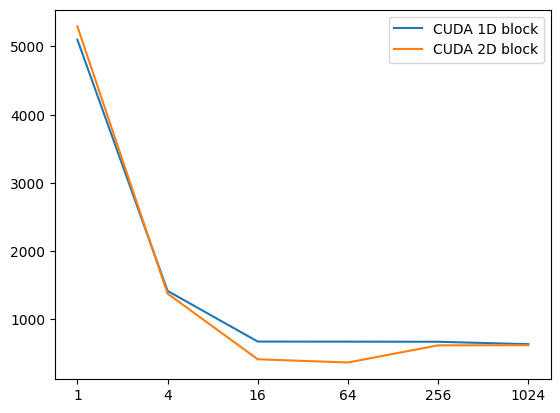

In [6]:
import matplotlib.pyplot as plt

files = [
    'cuda_1D_2048_1',
    'cuda_1D_2048_4',
    'cuda_1D_2048_16',
    'cuda_1D_2048_64',
    'cuda_1D_2048_256',
    'cuda_1D_2048_1024',
    'cuda_2D_2048_1',
    'cuda_2D_2048_2',
    'cuda_2D_2048_4',
    'cuda_2D_2048_8',
    'cuda_2D_2048_16',
    'cuda_2D_2048_32',
]
measuredTime = []
sizes = ['1', '4', '16', '64', '256', '1024']

for file in files:
    openFile = open(f'files/{file}.out', 'r')
    measuredTime.append(float(openFile.read()))

print(measuredTime)

fig, ax = plt.subplots()
ax.plot(sizes, measuredTime[0:6], label="CUDA 1D block")
ax.legend()
ax.plot(sizes, measuredTime[6:12], label="CUDA 2D block")
ax.legend()
plt.show()